In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import shutil
import warnings

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
# Paths
DATASET_ZIP = "respiratory.zip"
EXTRACTED_PATH = "lung_disease_dataset"
SATELLITE_PATH = "satellite_lung_disease_dataset"

In [3]:
import zipfile

with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(EXTRACTED_PATH)

if not os.path.exists(SATELLITE_PATH):
    shutil.copytree(EXTRACTED_PATH, SATELLITE_PATH)

def convert_to_satellite_images_with_filters(base_path):
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    # Apply Gaussian blur for smoothness
                    img = cv2.GaussianBlur(img, (5, 5), 0)

                    # Apply red and yellow filters
                    img[:, :, 1] = cv2.addWeighted(img[:, :, 1], 0.5, img[:, :, 2], 0.5, 0)  # Combine Green and Blue
                    img[:, :, 0] = 0 
                    
                    # Normalize the image for uniformity
                    normalized_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
                    
                    # Save the modified image
                    cv2.imwrite(img_path, normalized_img)

convert_to_satellite_images_with_filters(SATELLITE_PATH)

In [4]:
# Data preprocessing
image_size = (224, 224)
batch_size = 32

In [5]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)


In [6]:
train_generator = datagen.flow_from_directory(
    os.path.join(SATELLITE_PATH, "Lung Disease Dataset", "train"),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    os.path.join(SATELLITE_PATH, "Lung Disease Dataset", "val"),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    os.path.join(SATELLITE_PATH, "Lung Disease Dataset", "test"),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


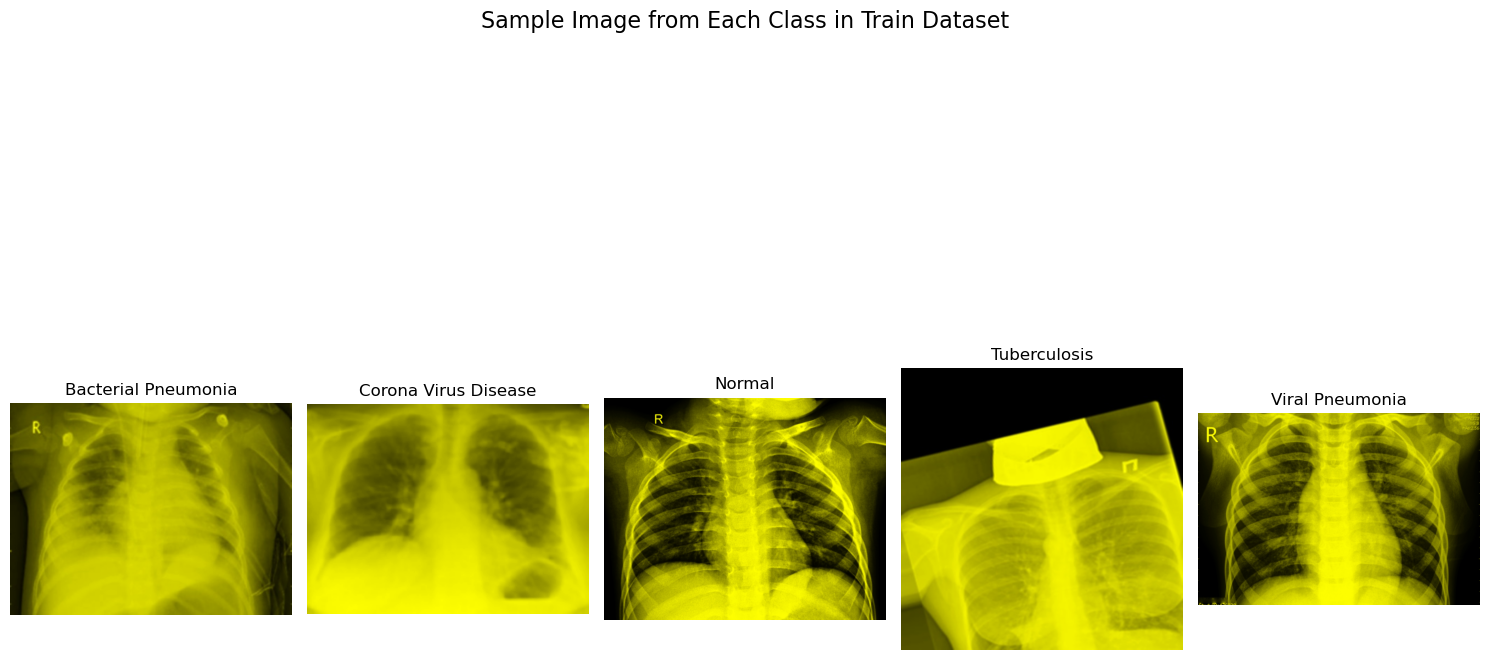

In [7]:
train_path = os.path.join("satellite_lung_disease_dataset", "Lung Disease Dataset", "train")
class_images = {}


for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
       
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
                    class_images[class_name] = img
                    break

# Plot the images
plt.figure(figsize=(15, 10))
for i, (class_name, img) in enumerate(class_images.items(), start=1):
    plt.subplot(1, len(class_images), i)
    plt.imshow(img)
    plt.title(class_name, fontsize=12)
    plt.axis('off')

plt.suptitle("Sample Image from Each Class in Train Dataset", fontsize=16)
plt.tight_layout()
plt.show()


In [9]:
# Loaded pre-trained ImageNet model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Added custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# Train the model
epochs = 30
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/30


190/190 [==============================] - 369s 2s/step - loss: 0.6217 - accuracy: 0.7436 - val_loss: 0.5340 - val_accuracy: 0.7803
Epoch 2/30
190/190 [==============================] - 349s 2s/step - loss: 0.4461 - accuracy: 0.8178 - val_loss: 0.4971 - val_accuracy: 0.7951
Epoch 3/30
190/190 [==============================] - 356s 2s/step - loss: 0.4104 - accuracy: 0.8304 - val_loss: 0.4557 - val_accuracy: 0.8105
Epoch 4/30
190/190 [==============================] - 355s 2s/step - loss: 0.3767 - accuracy: 0.8421 - val_loss: 0.4104 - val_accuracy: 0.8294
Epoch 5/30
190/190 [==============================] - 351s 2s/step - loss: 0.3617 - accuracy: 0.8490 - val_loss: 0.3998 - val_accuracy: 0.8358
Epoch 6/30
190/190 [==============================] - 353s 2s/step - loss: 0.3430 - accuracy: 0.8583 - val_loss: 0.4092 - val_accuracy: 0.8343
Epoch 7/30
190/190 [==============================] - 323s 2s/step - loss: 0.3307 - accuracy: 0.8616 - val_loss: 0.4638 - val_accuracy: 0.81

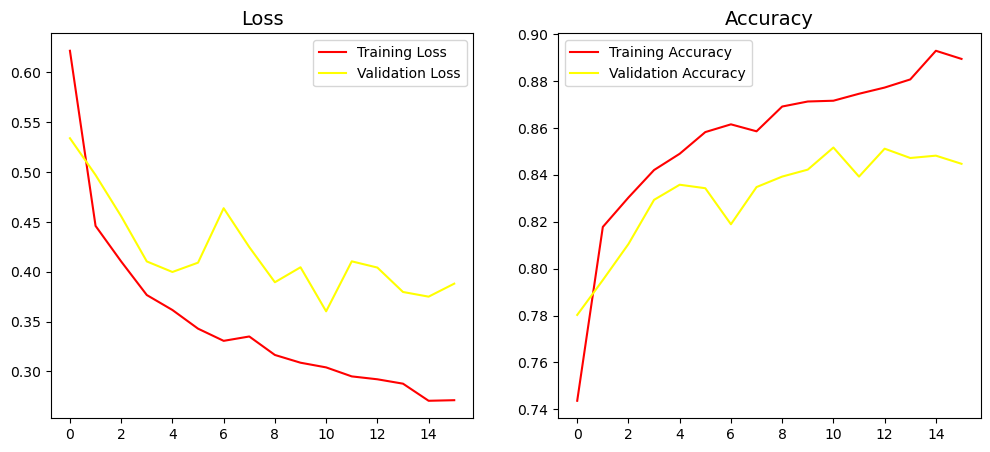

In [14]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='yellow')
plt.title('Loss', fontsize=14)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='yellow')
plt.title('Accuracy', fontsize=14)
plt.legend()

plt.show()

In [15]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

64/64 [==============================] - 73s 1s/step - loss: 0.3548 - accuracy: 0.8514
Test Accuracy: 0.85


In [16]:
# Confusion Matrix and Classification Report
val_steps = test_generator.samples // test_generator.batch_size
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

63/63 [==============================] - 70s 1s/step


In [17]:
# Generate predictions for the test set
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes


print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred_classes: {len(y_pred_classes)}")

64/64 [==============================] - 68s 1s/step
Length of y_true: 2025
Length of y_pred_classes: 2025


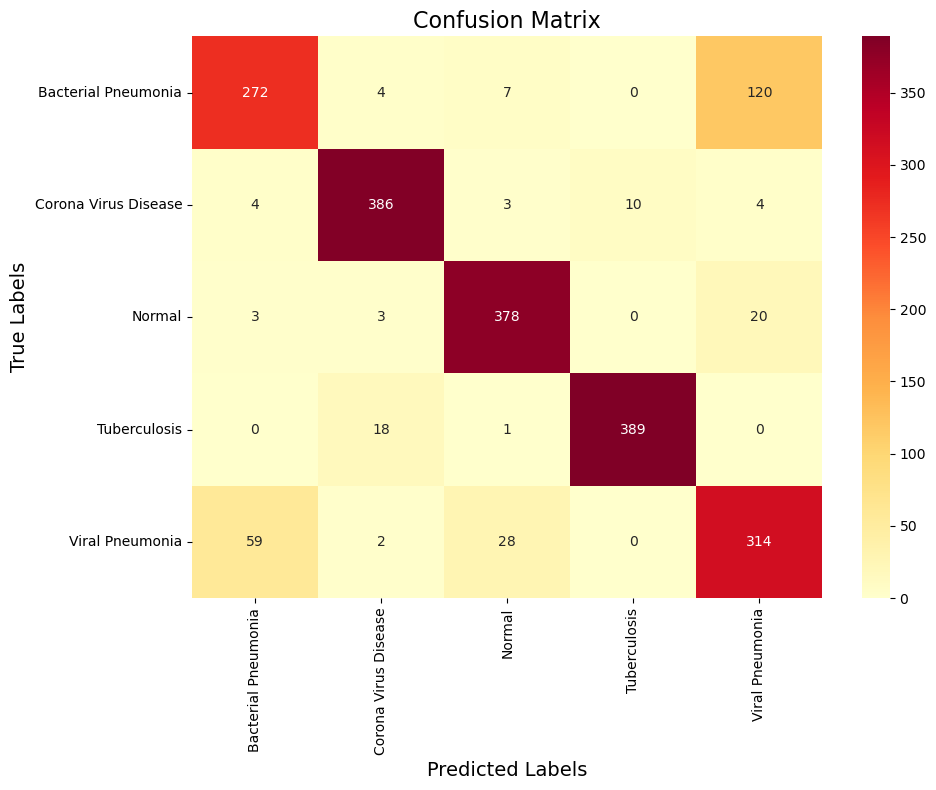

In [22]:
import seaborn as sns
# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='YlOrRd', 
    xticklabels=target_names, 
    yticklabels=target_names
)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()

In [23]:
target_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred_classes, target_names=target_names)
print("\nClassification Report:")
print(class_report)


Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.80      0.67      0.73       403
Corona Virus Disease       0.93      0.95      0.94       407
              Normal       0.91      0.94      0.92       404
        Tuberculosis       0.97      0.95      0.96       408
     Viral Pneumonia       0.69      0.78      0.73       403

            accuracy                           0.86      2025
           macro avg       0.86      0.86      0.86      2025
        weighted avg       0.86      0.86      0.86      2025



In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle

In [25]:
file_path = 'vaccine_data.csv' 
data = pd.read_csv(file_path)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       330 non-null    object
 1   sentiment  330 non-null    object
 2   category   330 non-null    object
dtypes: object(3)
memory usage: 7.9+ KB


In [27]:
data.head(10)

,text,sentiment,category
0,Vaccines are crucial for eradicating diseases ...,POSITIVE,Pro-Vaccine
1,I think vaccines are a government conspiracy t...,NEGATIVE,Anti-Vaccine
2,Vaccination campaigns have saved millions of l...,POSITIVE,Pro-Vaccine
3,I'm not sure if vaccines are really necessary ...,NEGATIVE,Anti-Vaccine
4,COVID-19 vaccines are a triumph of modern scie...,POSITIVE,Pro-Vaccine
5,My neighbor said vaccines cause more harm than...,NEGATIVE,Anti-Vaccine
6,Getting vaccinated is the best way to protect ...,NEGATIVE,Anti-Vaccine
7,The new vaccine seems rushed; I don't trust it.,NEGATIVE,Anti-Vaccine
8,I got vaccinated to keep my community safe fro...,NEGATIVE,Anti-Vaccine
9,I've read some scary stories about vaccine sid...,POSITIVE,Pro-Vaccine


In [28]:
data.shape

(330, 3)

In [29]:
data.describe()

,text,sentiment,category
count,330,330,330
unique,329,3,3
top,Both sides of the vaccine debate have valid po...,POSITIVE,Pro-Vaccine
freq,2,167,167


In [30]:
data.isnull().sum()

text         0
sentiment    0
category     0
dtype: int64

In [31]:
data['text_length'] = data['text'].apply(len)

Text(0, 0.5, 'Frequency')

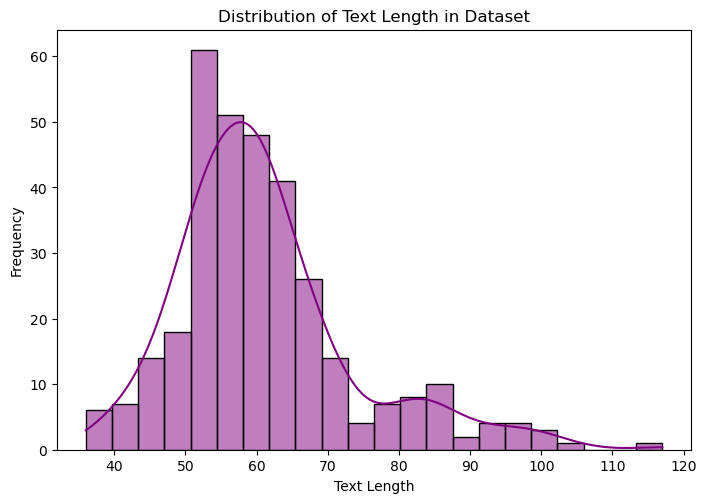

In [32]:
plt.figure(figsize=(18, 12))

# 1. Distribution of text length
plt.subplot(2, 2, 1)
sns.histplot(data['text_length'], kde=True, color='purple')
plt.title("Distribution of Text Length in Dataset")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

Text(0, 0.5, 'Count')

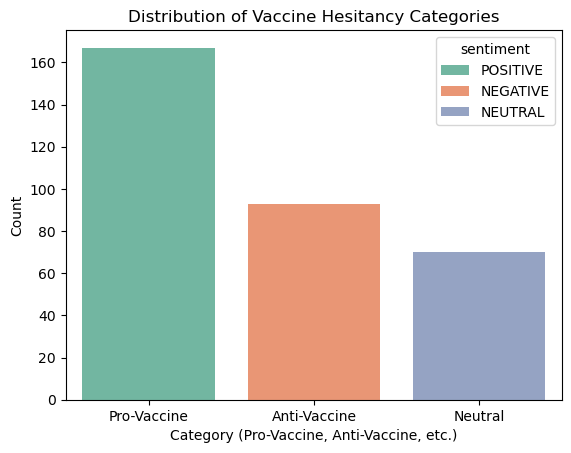

In [33]:
# 2. Distribution of target variable ('category') with hue
plt.subplot(1, 1, 1)
sns.countplot(x='category', data=data, hue='sentiment', palette='Set2')
plt.title("Distribution of Vaccine Hesitancy Categories")
plt.xlabel("Category (Pro-Vaccine, Anti-Vaccine, etc.)")
plt.ylabel("Count")

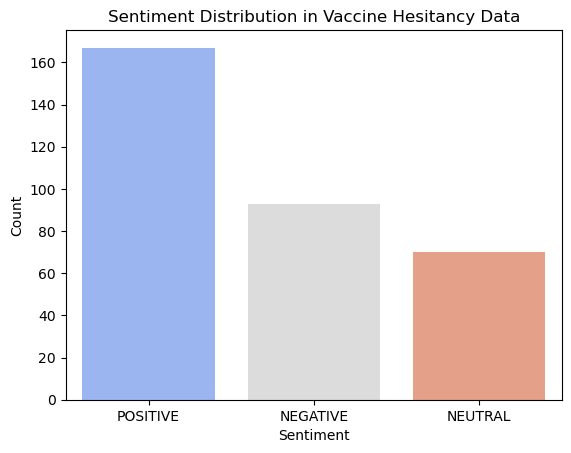

In [34]:
# 3. Sentiment distribution (if applicable)
if 'sentiment' in data.columns:
    plt.subplot(1, 1, 1)
    sns.countplot(x='sentiment', data=data, hue='sentiment', palette='coolwarm')
    plt.title("Sentiment Distribution in Vaccine Hesitancy Data")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")

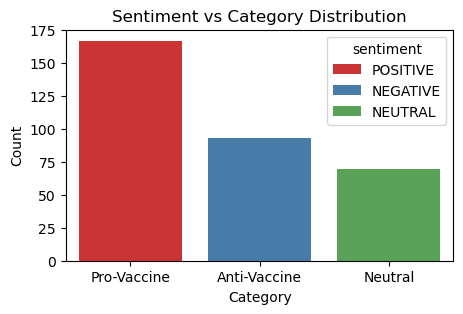

In [35]:
# 5. Bar plot for sentiment vs category distribution (if 'sentiment' exists)
if 'sentiment' in data.columns:
    plt.figure(figsize=(5, 3))
    sns.countplot(x='category', hue='sentiment', data=data, palette='Set1')
    plt.title("Sentiment vs Category Distribution")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.show()

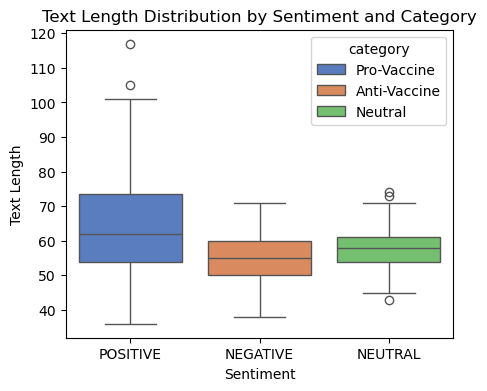

In [36]:
# 6. Distribution of sentiment across text length with hue
if 'sentiment' in data.columns:
    plt.figure(figsize=(5, 4))
    sns.boxplot(x='sentiment', y='text_length', data=data, hue='category', palette='muted')
    plt.title("Text Length Distribution by Sentiment and Category")
    plt.xlabel("Sentiment")
    plt.ylabel("Text Length")
    plt.show()


In [37]:
data = pd.read_csv('vaccine_data.csv')
print("Unique values in 'category' column:")
print(data['category'].unique())

Unique values in 'category' column:
['Pro-Vaccine' 'Anti-Vaccine' 'Neutral']


In [38]:
data['category'].value_counts()
data['category'] = data['category'].map({'Pro-Vaccine': 1, 'Anti-Vaccine': 0})
print(f"NaN values in 'category' after encoding: {data['category'].isna().sum()}")

NaN values in 'category' after encoding: 70


In [39]:
data.head()

,text,sentiment,category
0,Vaccines are crucial for eradicating diseases ...,POSITIVE,1.0
1,I think vaccines are a government conspiracy t...,NEGATIVE,0.0
2,Vaccination campaigns have saved millions of l...,POSITIVE,1.0
3,I'm not sure if vaccines are really necessary ...,NEGATIVE,0.0
4,COVID-19 vaccines are a triumph of modern scie...,POSITIVE,1.0


In [40]:
# Drop rows where 'category' is NaN after encoding
data = data.dropna(subset=['category'])
X = data['text']  
y = data['category']  # Target: Vaccine sentiment (Pro or Anti)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Vectorize the text data using TF-IDF (Term Frequency - Inverse Document Frequency)
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [42]:
# Initialize the machine learning model (Logistic Regression)
model = LogisticRegression(max_iter=5000)

# Train the model on the training data
model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display detailed classification report (precision, recall, f1-score)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 90.38%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78        13
         1.0       0.90      0.97      0.94        39

    accuracy                           0.90        52
   macro avg       0.90      0.83      0.86        52
weighted avg       0.90      0.90      0.90        52



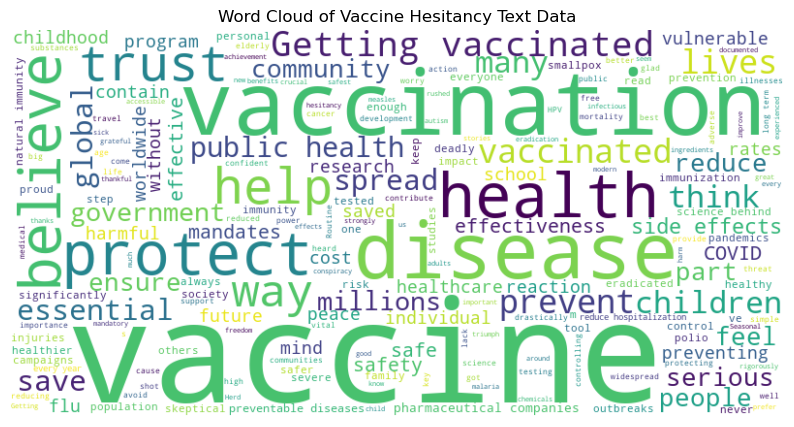

In [43]:
# 7. Word Cloud visualization (for a textual analysis)
from wordcloud import WordCloud

text_data = ' '.join(data['text'].dropna())  # Combine all the text into a single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Vaccine Hesitancy Text Data")
plt.axis('off')
plt.show()